In [1487]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

In [1488]:
train_df=pd.read_csv("../data/train.csv")
test_df=pd.read_csv("../data/test.csv")

In [1489]:
set(list(train_df.columns))-set(list(test_df.columns))

{'Transported'}

In [1490]:
train_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


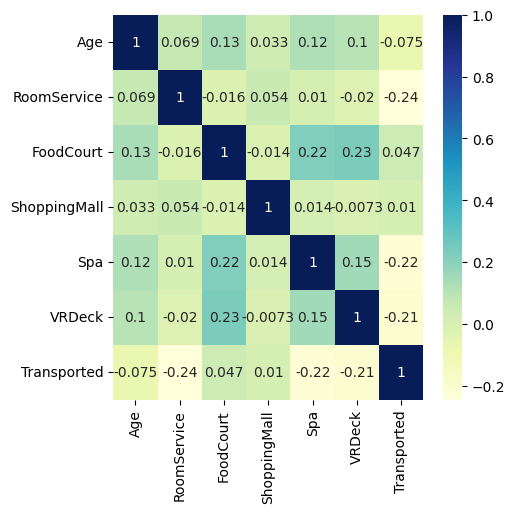

In [1491]:
plt.figure(figsize=(5,5))
sns.heatmap(train_df.corr(numeric_only=True), cmap='YlGnBu', annot=True)
plt.show()

In [1492]:
def drop_name(df):
    df.drop("Name", axis=1, inplace=True)

In [1493]:
train_df['Cabin'].value_counts()

Cabin
G/734/S     8
F/1194/P    7
B/201/P     7
G/981/S     7
G/109/P     7
           ..
E/56/P      1
A/98/P      1
G/1499/S    1
G/1500/S    1
D/252/P     1
Name: count, Length: 6560, dtype: int64

In [1494]:
train_df.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [1495]:
def cabin_engineer(df:list):
    for i in df:
        i['Cabin']=i['Cabin'].fillna("U/NaN/U")
        i[['Deck', 'num', 'side']]=i['Cabin'].str.split("/", expand=True)
        i['Deck']=i['Deck'].map({'F':0, 'G':1, 'E':2, 'B':3, 'C':4, 'D':5, 'A':6, 'T':7})
        i['num'] = i['num'].astype(float)
        i.drop("Cabin", axis=1, inplace=True)
cabin_engineer([train_df, test_df])

In [1496]:
string_imputer=Pipeline([
    ('string_imputing', SimpleImputer(strategy='most_frequent')),
    ('str_one_encoding', OneHotEncoder(handle_unknown='infrequent_if_exist', drop='if_binary', max_categories=7))
])

In [1497]:
str_to_be_encoded=['Destination', 'HomePlanet', 'side', 'VIP', 'CryoSleep']

In [1498]:
ct=ColumnTransformer([
    ('string_magic', string_imputer, str_to_be_encoded),
    ('number_imputer', SimpleImputer(strategy='median'), ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Age', 'num']),
], remainder='passthrough')

In [1499]:
pipeline=Pipeline([
    ('pre_process', ct),
    ('model', XGBClassifier(
        n_estimators=500,
        max_depth=5,
        learning_rate=0.05,
        random_state=42,
        use_label_encoder=False,
        eval_metric='logloss'
    ))
])

In [1500]:
for i in [train_df, test_df]:
    drop_name(i)

In [1501]:
X=train_df.drop('Transported', axis=1)
y=train_df['Transported']
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.33, random_state=42)

In [1502]:
# pipeline.fit(X_train, y_train)

In [1503]:
# y_pred=pipeline.predict(X_test)
# y_pred

In [1504]:
# accuracy_score(y_test, y_pred)

In [1505]:
pipeline.fit(X, y)
result=pipeline.predict(test_df)
result_df=pd.DataFrame(result, columns=['Transported'])

c:\Users\hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:199: UserWarning: [21:45:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [1506]:
result_df['Transported']=result_df['Transported'].map({0:False, 1:True})

In [1507]:
result_df=pd.concat([test_df['PassengerId'], result_df], axis=1)

In [1508]:
result_df.head()

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True


In [1509]:
result_df.to_csv('result.csv', index=False)